In [92]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import numpy as np
import random
import math
import EoN
import seaborn as sns
import time

# New Imports
#from ctrace.contact_tracing import *
#from ctrace.constraint import *
#from ctrace.solve import *
#from ctrace.simulation import *
#from ctrace.restricted import *
from ctrace.simulation import *
from ctrace.dataset import *
from ctrace.recommender import *
from ctrace.problem_label import *
from ctrace.utils import *
from ctrace.drawing import *
from collections import Counter



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
G_mont = load_graph_montgomery_labels()
with open(PROJECT_ROOT / "data" / "SIR_Cache" / "c7.json", 'r') as infile:
    j = json.load(infile)
    (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
    infections = j["infections"]
state = InfectionState(G_mont, (S, I1, I2, R), 10000, "none", 0.05, True, 0.8, True, 1, 1)
G = G_mont

In [94]:
# # <================ Adjustments ================>

# # Letter Description
# # p: (0, 4) preschool
# # s: (5, 17) school-aged
# # a: (18, 49) adults
# # o: (50, 64) older-adults
# # g: (65, ) golden-aged

# # None restrictions no restrictions for the category per-se, but global budget constraint still holds

# # No Restrictions
# policy_A = {
#     0: None,
#     1: None,
#     2: None,
#     3: None,
#     4: None,
# }

# # Proportional
# policy_B = {
#     0: 1,
#     1: 1,
#     2: 1,
#     3: 1,
#     4: 1,
# }
# # Double for golden-aged
# policy_C = {
#     0: 1,
#     1: 1,
#     2: 1,
#     3: 1,
#     4: 2,
# }
# # Halved for adults and older adults
# policy_D = {
#     0: 1,
#     1: 1,
#     2: 0.5,
#     3: 0.5,
#     4: 1,
# }

# # Unrestricted golden-aged and preschool
# policy_E = {
#     0: None,
#     1: 1,
#     2: 0.5,
#     3: 0.5,
#     4: None,
# }

# fair_policies = {
#     'A': policy_A,
#     'B': policy_B,
#     'C': policy_C,
#     'D': policy_D,
#     'E': policy_E,
# }

# def adjusted_allocation(pop_counts, policy, budget=None):
#     """
#     Rescales and allows for None in policy factors.
#     Filters out the nones, and performs rescaling on the remaining numbers.

#     pop_counts: dict[pop_id] -> count
#     policy: dict[pop_id] -> proportion factor
#     """
#     scales = [v for k,v in policy.items() if v is not None]
#     indices = [k for k,v in policy.items() if v is not None]
#     nulls = [k for k,v in policy.items() if v is None]
#     total = sum(scales)
#     if total == 0:
#         return policy # 0 -> 0, None -> None
    
#     counts = rescale([pop_counts[i] for i in indices], scales, budget)
#     counts = round_fracs(counts)
    
#     soln = {}
#     for k in policy:
#         if k in nulls:
#             soln[k] = None
#         else:
#             soln[k] = counts[indices.index(k)]
#     # Doesn't preserve order
# #     soln = {indices[i]: scale for i, scale in enumerate(scales)}
# #     soln.update({k: None for k in nulls})
#     return soln

# def rescale(nums, scales, budget=None):
#     """
#     Rescale nums with scales to budget. Budget defaults to sum(nums)
    
#     Ex:
#     nums = [10, 20]
#     scale = [2, 1]
#     will return [15, 15]
#     """
#     raw = np.multiply(nums, scales)
#     if np.sum(raw) == 0:
#         raise ValueError("Rescaling denominator may not 0")
#     if budget is None:
#         budget = np.sum(nums)
#     return list(raw * budget / np.sum(raw))

# def round_fracs(amts):
#     """
#     Rounds array, ensuring that sum(result) == sum(amts)
#     Using even-rounding (rounds to the nearest even for 0.5)
#     All fractions are closed (accumulated) in last element.
#     """
#     first = [round(amt) for amt in amts[:-1]]
#     return first + [int(sum(amts) - sum(first))]

# assert rescale([10, 20], [2, 1]) == [15, 15]
# assert rescale([10, 10], [3, 1]) == [15, 5]

# assert rescale([10, 20], [2, 1], 60) == [30, 30]
# assert rescale([10, 10], [3, 1], 40) == [30, 10]

<BarContainer object of 5 artists>

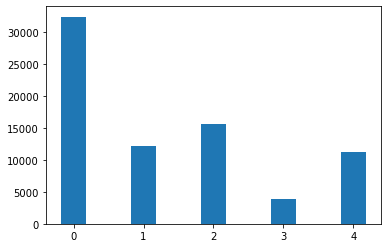

In [105]:
# original distribution
fig, ax = plt.subplots(1,1)
pop_counts = Counter(G.nodes[n].get('age_group') for n in G.nodes)
pop_counts = {k: pop_counts[k] for k in sorted(pop_counts)}
ax.bar(pop_counts.keys(), pop_counts.values(), .35, label='Men')
# ax.set_ylim(0,50000)

A
{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
B
{0: 344, 1: 129, 2: 166, 3: 42, 4: 118}
C
{0: 299, 1: 112, 2: 144, 3: 36, 4: 209}
D
{0: 395, 1: 148, 2: 95, 3: 24, 4: 138}


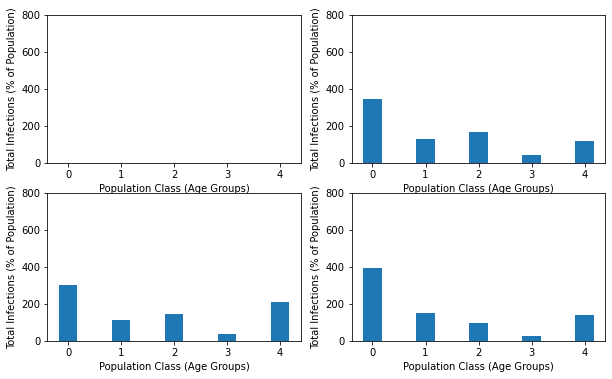

In [125]:
# def compute_label_budgets(G, scales):
#     pop_counts = Counter(G.nodes[n].get('age_group') for n in G.nodes)
#     adjusted = adjusted_allocation(pop_counts, scales)
    
#     return {k: adjusted[k] for k in sorted(adjusted)}


fig, axes = plt.subplots(2,2, figsize=(10, 6))

for ax, policy in zip(axes.flat, fair_policies):
    print(policy)
    budgets = compute_label_budgets(G_mont, fair_policies[policy], 800)
    for b in budgets:
        budgets[b] = 0 if budgets[b] is None else budgets[b]
    print(budgets)
    ax.bar(budgets.keys(), budgets.values(), .35, label='Men')
    ax.set_ylim(0,800)
    
    ax.set_xlabel("Population Class (Age Groups)")
    ax.set_ylabel("Total Infections (% of Population)")

In [15]:
pop_counts = dict(Counter(age_groups.values()))

Counter({2: 15648, 1: 12178, 0: 32401, 4: 11296, 3: 3934})

In [ ]:
compute_label_budgets(G)

In [131]:

from_cache = 'b5.json'
graph = G_mont
transmission_rate=.05
transmission_known=True
compliance_rate=0.8
compliance_known=True
discovery_rate=1
snitch_rate=1
agent=De
with open(PROJECT_ROOT / "data" / "SIR_Cache" / from_cache, 'r') as infile:
    j = json.load(infile)

    (S, I1, I2, R) = (j["S"], j["I1"], j["I2"], j["R"])
    infections = j["infections"] # An array of previous infection accounts

state = InfectionState(graph, (S, I1, I2, R), budget, policy, transmission_rate,
                       transmission_known, compliance_rate, compliance_known, discovery_rate, snitch_rate)


while len(state.SIR.I1) + len(state.SIR.I2) != 0:
    to_quarantine = agent(state)
    state.step(to_quarantine)
    infections.append(len(state.SIR.I2))


NetworkXError: The node 98312 is not in the graph.

In [155]:
import pytest
def pair_greedy(pairs, label_budgets, budget, mapper):
    """
    pairs: (obj_val, id)
    label_budgets: label -> budget
    budget: int
    mapper: id -> label
    """
    label_budgets = {k: v for k, v in label_budgets.items() if v is not None}
    
    result = set()
    for val, v in pairs:
        if len(result) >= budget:
            break
        label = mapper(v)
        if label not in label_budgets:
            result.add(v)
        else:
            # Add greedily until budget runs out for a particular label
            if label_budgets[label] > 0: 
                result.add(v)
                label_budgets[label] -= 1
    return result
    

In [141]:
print([(v, k) for k, v in pairs])

[(2, 0), (3, 1), (4, 2), (5, 3), (10, 3), (10, 4)]


In [156]:
seed=42
G, pos = small_world_grid(
    width=10,
    max_norm=False,
    sparsity=0,
    p=1,
    local_range=1,
    num_long_range=0,
    r=2,
    seed=seed
)

100%|██████████| 100/100 [00:00<00:00, 5115.13it/s]
